## Importing libraries

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
import Desktop.Project
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.3.0


## Understanding data

In [4]:
for expression in os.listdir("train/"):
    print(str(len(os.listdir("train/"+expression)))+" "+expression)

3995 angry
436 disgust
4097 fear
7214 happy
4965 neutral
4830 sad
3171 surprise


## Creating training and validation batches

In [5]:
img_size=48
batch_size=64
datagen_train=ImageDataGenerator(horizontal_flip=True)
train_generator=datagen_train.flow_from_directory("train/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)
datagen_validation=ImageDataGenerator(horizontal_flip=True)
validation_generator=datagen_train.flow_from_directory("train/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

Found 28708 images belonging to 7 classes.
Found 28708 images belonging to 7 classes.


## Creating a CNN

In [13]:
model=Sequential()

model.add(Conv2D(64,(3,3),padding='same',input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))
opt=Adam(0.0005)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)      

## Training and validation

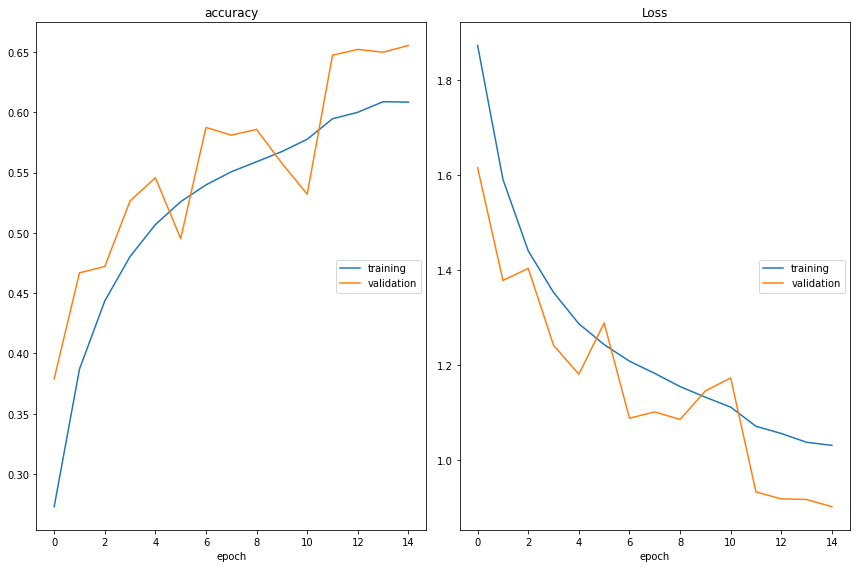

accuracy
	training         	 (min:    0.273, max:    0.609, cur:    0.608)
	validation       	 (min:    0.379, max:    0.655, cur:    0.655)
Loss
	training         	 (min:    1.032, max:    1.873, cur:    1.032)
	validation       	 (min:    0.903, max:    1.616, cur:    0.903)

Epoch 00015: saving model to model_weights.h5
448/448 [==============================] - 550s 1s/step - loss: 1.0318 - accuracy: 0.6084 - val_loss: 0.9027 - val_accuracy: 0.6553


In [16]:
epochs=15
steps_per_epoch=train_generator.n//batch_size
validation_steps=validation_generator.n//batch_size

reduce_lr=ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2,min_lr=0.00001,mode='auto')
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr]
history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

In [17]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)